In [1]:
using CSV, DataFrames, CategoricalArrays, Statistics, StatsPlots

# read from files created by R with baseline risk probas computed via cox models

# modified 9/20: using risk stratification with preds by cox trained on treated instead on untreated only!
train_data = CSV.read("traindata/unmatched_with_risk_preds.csv", DataFrame) #1259x15 size (70% subset from cox model split in R Studio)
unique(train_data.:adjuvantchemo)
summary(train_data)
float_cols = names(train_data, Float64)
int_cols = names(train_data, Int64)
df_treated = filter(row -> row.adjuvantchemo == 1, train_data)


Row,age,size,cea_carcinoembryonic.antigen,number_liver_mets,DFI.12,T_stage,N_stage,rightleft.Rec,extrahepatic.disease,R0,KRAS,adjuvantchemo,died,time_to_event,dying_prob_5y
,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,58.0,4.0,1.4,4.0,0,3,0,0,1,0,1,1,0,1104.88,0.797212
2,48.0,4.0,153.0,1.0,0,3,0,2,1,1,1,1,1,535.7,0.71681
3,32.0,1.0,3.0,2.0,1,2,1,2,1,0,1,1,0,995.306,0.721969
4,65.0,3.0,43.1,2.0,0,3,0,1,1,0,1,1,0,508.306,0.735128
5,38.0,8.7,869.7,2.0,1,4,1,1,1,0,1,1,0,1114.01,0.908281
6,65.0,4.5,2.3,1.0,0,4,1,1,1,1,1,1,1,678.756,0.909574
7,61.0,3.0,1021.4,2.0,1,3,1,1,0,0,1,1,1,706.15,0.764577
8,32.0,1.0,3.0,5.0,1,2,1,2,1,0,1,1,0,980.087,0.772473
9,83.0,2.5,3.4,2.0,1,4,1,0,1,0,1,1,0,115.662,0.920531


**Prognostic buckets**

In [2]:
# Function to categorize risk probabilities into buckets
function categorize_risk_in_buckets(data,num_buckets)
    df = deepcopy(data)
    
    # Compute quantiles to determine bucket boundaries
    quantiles = [quantile(df[:, :dying_prob_5y], q) for q in LinRange(0, 1, num_buckets+1)]

    # Assign each patient to a bucket based on quantiles
    df[:, :risk_bucket] .= 0  # Initialize bucket labels

    for i in 1:num_buckets
        mask = (quantiles[i] .<= df[:, :dying_prob_5y]) .& (df[:, :dying_prob_5y] .<= quantiles[i+1])
        df[mask, :risk_bucket] .= i
    end
            # Display bin edge values
    println("Bin Edge Values risk:")
    for i in 1:length(quantiles)-1
        println("Bucket $i: $(round(quantiles[i],digits=2)) - $(round(quantiles[i+1],digits=2))")
    end
      return df
end


categorize_risk_in_buckets (generic function with 1 method)

In [3]:
function categorize_risk_in_deciles(data, num_buckets)
    df = deepcopy(data)

    # Initialize bucket boundaries
    bucket_boundaries = collect(0:0.1:1)

    # Assign each patient to a bucket based on deciles
    df[:, :risk_bucket] .= 0  # Initialize bucket labels
    for i in 1:num_buckets
        mask = (bucket_boundaries[i] .<= df[:, :dying_prob_5y]) .& (df[:, :dying_prob_5y] .< bucket_boundaries[i+1])
        df[mask, :risk_bucket] .= i
    end

    # Display bin edge values
    println("Bin Edge Values risk:")
    for i in 1:length(bucket_boundaries)-1
        println("Bucket $i: $(bucket_boundaries[i]) - $(bucket_boundaries[i+1])")
    end

    return df
end

# Add a new column "RiskBucket" to the DataFrame
train_data = categorize_risk_in_deciles(train_data, 10);

Bin Edge Values risk:
Bucket 1: 0.0 - 0.1
Bucket 2: 0.1 - 0.2
Bucket 3: 0.2 - 0.3
Bucket 4: 0.3 - 0.4
Bucket 5: 0.4 - 0.5
Bucket 6: 0.5 - 0.6
Bucket 7: 0.6 - 0.7
Bucket 8: 0.7 - 0.8
Bucket 9: 0.8 - 0.9
Bucket 10: 0.9 - 1.0


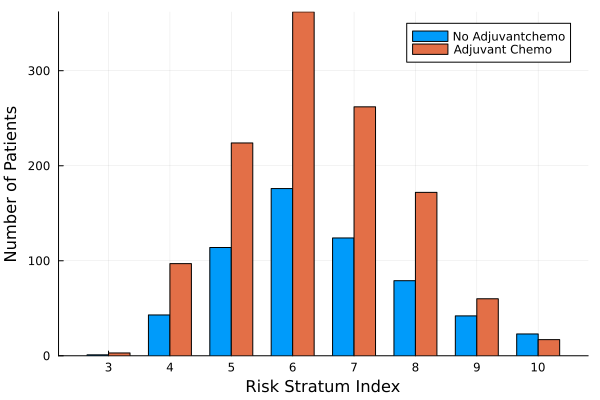

In [4]:
function plot_histogram(X, add_to_title)
    # Group by RiskBucket and RxRegimen, then count the number of patients
    grouped_df = combine(groupby(X, [:risk_bucket, :adjuvantchemo]), nrow => :Patients)
    # Filter DataFrame for "None" and other regimens
    df_none = filter(row -> row.adjuvantchemo == 0, grouped_df)
    df_treated = filter(row -> row.adjuvantchemo == 1, grouped_df)
    
    # Group by RiskBucket and sum the number of patients for each regimen
    grouped_none = combine(groupby(df_none, :risk_bucket), :Patients => sum => :NonePatients)
    grouped_treated = combine(groupby(df_treated, :risk_bucket), :Patients => sum => :TreatedPatients)
    # Merge DataFrames on RiskBucket
    merged_df = innerjoin(grouped_none, grouped_treated, on=:risk_bucket)
    # Create a grouped bar plot with two bars side by side for each risk bucket
    groupedbar(merged_df[!, :risk_bucket], hcat(merged_df[!, :NonePatients], merged_df[!, :TreatedPatients]),
        bar_position=:dodge, 
        bar_width=0.7, 
        label=["No Adjuvantchemo" "Adjuvant Chemo"],
        xlabel="Risk Stratum Index", ylabel="Number of Patients",
       #title= "Histogram"*add_to_title,
        legend=:topright, fmt=:png)
    xticks!(1:1:maximum(merged_df[!, :risk_bucket]))
        
    # Save the plot as a PNG file
    #savefig("plots_and_metrics/histogram_"*add_to_title*".png")
   
end
hist = plot_histogram(train_data, " full cohort, unmatched")
savefig(hist, "plots_and_metrics/histogram_before.png")
hist


In [5]:
using DataFrames
grouped_df = combine(groupby(train_data, [:risk_bucket, :adjuvantchemo]), nrow => :NumPatients)
#display(grouped_df)
# Group by risk_bucket and check if each bucket has both adjuvantchemo values
valid_buckets = filter(row -> row.NumPatients >= 20, grouped_df)
display(valid_buckets)
# Find the minimum number of patients per regimen
min_bucket_by_regimen = combine(groupby(valid_buckets, :adjuvantchemo), :NumPatients => minimum => :MinPatients)
#display(min_bucket_by_regimen)
# Find the smallest number of patients in the entire DataFrame
global_min_bucket_size = minimum(min_bucket_by_regimen.MinPatients)

# Display the result
println("Bucket with the smallest number of patients:")
display(filter(row -> row.MinPatients == global_min_bucket_size, min_bucket_by_regimen))
print(global_min_bucket_size)
display(grouped_df)

Row,risk_bucket,adjuvantchemo,NumPatients
,Int64,Int64,Int64
1,4,0,43
2,4,1,97
3,5,0,114
4,5,1,224
5,6,0,176
6,6,1,362
7,7,0,124
8,7,1,262
9,8,0,79


Bucket with the smallest number of patients:


Row,adjuvantchemo,MinPatients
,Int64,Int64
1,0,23


23

Row,risk_bucket,adjuvantchemo,NumPatients
,Int64,Int64,Int64
1,3,0,1
2,3,1,3
3,4,0,43
4,4,1,97
5,5,0,114
6,5,1,224
7,6,0,176
8,6,1,362
9,7,0,124


In [6]:
function get_dfA_dfB(X1)
# store patient group with higher number of patients as dfB, lower number as dfA 
    if nrow(X1[X1."adjuvantchemo" .== 0,:]) <  nrow(X1[X1."adjuvantchemo" .!= 0,:])
        dfA = X1[X1."adjuvantchemo" .== 0,:] 
        dfB = X1[X1."adjuvantchemo" .!= 0,:] 
    else 
        dfA = X1[X1."adjuvantchemo" .!= 0,:]
        dfB = X1[X1."adjuvantchemo" .== 0,:] 
    end
    return dfA, dfB
end
# Create a matrix of the distance between 2 feature vectors of Group A and B
using LinearAlgebra,StatsBase
# standardize numerical columns
function standardize_for_distance_matrix(data)
    # Identify columns containing vectors of Float64
    float_cols = names(data, Float64)

    # Identify columns containing Int64 (binary data)
    int_cols = names(data, Int64)

    # Select columns with vectors of Float64
    X = select(data, float_cols)
    # Get standard deviations for each column
    std_devs = [std(X[:, col]) for col in 1:size(X, 2)]
    # Standardize columns with vectors of Float64, excluding columns where the standard deviation is 0
    for (i, std_dev) in enumerate(std_devs)
        
        if std_dev == 0 || isnan(std_dev)
            println(" std is nan or 0 for column ", names(X)[i])            
            print(std_dev)
            
        else
            # Standardize the column
            X[:, i] .= zscore(X[:, i])
        end
    end
    

    # Combine standardized columns with columns containing Int64
    standardized_data = hcat(select(data, int_cols), X)
    
    # Get the order of columns after standardization
    column_order = vcat(int_cols, float_cols)
    return standardized_data
end


function get_distance_matrix(dfA, dfB)
    
    if nrow(dfA) < 2
        standardized_data_A = dfA
        standardized_data_B = dfB
    else
        # Standardize the data and get the column order
        standardized_data_A = standardize_for_distance_matrix(dfA)
        standardized_data_B = standardize_for_distance_matrix(dfB)
    end    
    # Define a function to map column names to keys in coeff_dict
    #get_coeff_key(col) = Symbol(col)
    
    # Get the coefficients in the correct order
    #coeff_order_A = [coeff_dict[get_coeff_key(col)] for col in column_order_A if haskey(coeff_dict, get_coeff_key(col))]
    #coeff_order_B = [coeff_dict[get_coeff_key(col)] for col in column_order_B if haskey(coeff_dict, get_coeff_key(col))]
    
        # Check for missing values in coeff_order_A
    #if any(ismissing, coeff_order_A)
    #    println("Missing values detected in coeff_dict")
    #            # Get the coefficients in the correct order and replace missing values with 0
    #    coeff_order_A = [coalesce(coeff_dict[get_coeff_key(col)], 0.0) for col in column_order_A]
    #    coeff_order_B = [coalesce(coeff_dict[get_coeff_key(col)], 0.0) for col in column_order_B]

   # end
   # println(coeff_order_A)
    # Get the matrices without the excluded columns
    A_mat = Matrix(standardized_data_A[:, Not([:adjuvantchemo,:risk_bucket,:time_to_event, :died,:dying_prob_5y,Symbol("DFI.12")])])
    B_mat = Matrix(standardized_data_B[:, Not([:adjuvantchemo,:risk_bucket,:time_to_event, :died,:dying_prob_5y,Symbol("DFI.12")])])
    
    # Check for NaN values
    nan_indices = hcat(findall(isnan, A_mat), findall(isnan, B_mat))
    if length(nan_indices) > 0
        println("NaN values are present in the matrix.")
    end
    # Check if coeff_order_A and coeff_order_B are equal
    #if coeff_order_A != coeff_order_B
    #    println("Coefficients for A and B are not equal.")
    #end
    # Calculate distances using weighted norms
   # weights = transpose(coeff_order_A)
    
    # L2 norm by default
    #distances = [norm((A_row - B_row) .* weights) for A_row in eachrow(A_mat), B_row in eachrow(B_mat)]
    distances = [norm(A_row - B_row) for A_row in eachrow(A_mat), B_row in eachrow(B_mat)]
    print(size(distances))                
    return distances
end


get_distance_matrix (generic function with 1 method)

In [7]:
## june 5: no longer 1-to-1 but relax the matching 
## --> can discard untreated patients that have outlier characteristic
using Gurobi, JuMP, LinearAlgebra, SparseArrays
function matching_optimizer(m,n,d_matrix, ratio, global_min_bucket_size=0)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    @variable(model,z[1:m,1:n],Bin) 
    
    for i = 1:m
        @constraint(model, sum(z[i,:]) <= 2) ## sep 19: try untreated vs treated with replacemnt
    end
    @constraints(model, begin 
        [j = 1:n], sum(z[:,j]) <= 2 ## sept 4: back to pairwise matching "without replacement"
        end)
    @constraint(model, sum(z) >= ratio*global_min_bucket_size) 
    
    @objective(model,Min, sum(sum(d_matrix[i,j]*z[i,j] for i=1:m) for j=1:n))
    # Solve the optimization problem
    optimize!(model)
    
    # Retrieve the objective value
    objective = JuMP.objective_value(model)
    
    return objective, value.(z)
end

function matching_optimizer_1to1(m,n,d_matrix, global_min_bucket_size=0)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    @variable(model,z[1:m,1:n],Bin) 
    for i = 1:m
        @constraint(model, sum(z[i,:]) == 1 ) 
    end
            
    @constraints(model, begin 
        [j = 1:n], sum(z[:,j]) <= 1
        end)
        
    @objective(model,Min, sum(sum(d_matrix[i,j]*z[i,j] for i=1:m) for j=1:n))
    # Solve the optimization problem
    optimize!(model)
    
    # Retrieve the objective value
    objective = JuMP.objective_value(model)
    
    return objective, value.(z)
end

using Dates  # For finer-grained time measurement if needed

function optimize_risk_range(file, df, ratio, global_min_bucket_size, one_to_one=false)
    risk_buckets = unique(df.risk_bucket)
    # Initialize total cost and time
    total_cost = 0
    total_time = 0.0  # Initialize total time accumulator
    
    for risk_bucket in risk_buckets
        println("Bucket number: ", risk_bucket)
        
        bucket_data = df[df.risk_bucket .== risk_bucket, :]
        dfA, dfB = get_dfA_dfB(bucket_data) # Use the coefficients dictionary for the current risk bucket

        distances = get_distance_matrix(dfA, dfB)
        m = size(dfA)[1]
        n = size(dfB)[1]

        # Measure time for optimization
        start_time = time()  # Start timer
        if one_to_one || m < ratio * global_min_bucket_size
            cost, z = matching_optimizer_1to1(m, n, distances, global_min_bucket_size)
        else
            cost, z = matching_optimizer(m, n, distances, ratio, global_min_bucket_size)
        end
        elapsed_time = time() - start_time  # Compute elapsed time
        total_time += elapsed_time  # Accumulate elapsed time
        
        println("Optimal cost: ", cost)
        println("Time taken for this bucket: ", elapsed_time, " seconds")
        
        total_cost += cost
        rows, cols, vals = findnz(sparse(z))
        # Scan through each column 1:n to discard the B patients who have not been matched to any of the m A patients
        println("size of dfA: ", size(dfA), "    size of dfB: ", size(dfB), 
                " UNIQUE: ", size(unique(rows)), size(unique(cols)))
        
        data = vcat(dfA[unique(rows), :], dfB[unique(cols), :])
        println("size of bucket dataframe = ", size(data))
        CSV.write(file, data, append=true)
        println("Bucket cost: ", cost)
        println("")
    end
    
    println("Cumulative cost: ", total_cost)
    println("Total optimization time: ", total_time, " seconds")
end


optimize_risk_range (generic function with 2 methods)

In [11]:
using Printf
file = "traindata/matched_train_timed.csv"  # Sample file name
titlerow = names(train_data)
# Generate range of ratio values from 1.5 to 2.0 in increments of 0.1
ratio_range = 1.0:0.1:1.0
for ratio_number in ratio_range
    println(ratio_number)
    new_file = file

    CSV.write(new_file, DataFrame([]); header=titlerow)
    # Call function with new file name
    optimize_risk_range(new_file, train_data, ratio_number, global_min_bucket_size)
    println(" ")
    df = CSV.read(new_file, DataFrame, pool=true)
    hist=plot_histogram(df, ", matched untreated with replacement")
    # Save the plot to a PNG file
    #savefig(hist, "plots_and_metrics/histogram_strata_from_treated_relaxed.png")
        
end

1.0
Bucket number: 6
(176, 362)Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-21
Optimal cost: 5.910129296760233
Time taken for this bucket: 0.3631479740142822 seconds
size of dfA: (176, 16)    size of dfB: (362, 16) UNIQUE: (18,)(21,)
size of bucket dataframe = (39, 16)
Bucket cost: 5.910129296760233

Bucket number: 8
(79, 172)Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-21
Optimal cost: 8.78819472811915
Time taken for this bucket: 0.07947707176208496 seconds
size of dfA: (79, 16)    size of dfB: (172, 16) UNIQUE: (16,)(19,)
size of bucket dataframe = (35, 16)
Bucket cost: 8.78819472811915

Bucket number: 9
(42, 60)Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-21
Optimal cost: 23.15917341148098
Time taken for this bucket: 0.016665935516357422 seconds
size of dfA: (42, 16)    size of dfB: (60, 16) UNIQUE: (17,)(17,)
size of bucket dataframe = (34, 16)
Bucket cos

In [5]:
file = "traindata/matched_train_equalized_.csv"  # Sample file name
df1 = CSV.read(replace(file, ".csv" => "r1" * ".csv"), DataFrame, pool=true)
println(size(df1))
df2 = CSV.read("traindata/matched_train_equalized_r1.0_relaxed.csv", DataFrame, pool=true)
hist_after=plot_histogram(df2, "full cohort, matched")
println(size(df2))

# Save the plot to a PNG file
#savefig(hist_after, "plots_and_metrics/histogram_after_relaxed_equalized.png")

(312, 16)


LoadError: UndefVarError: `plot_histogram` not defined

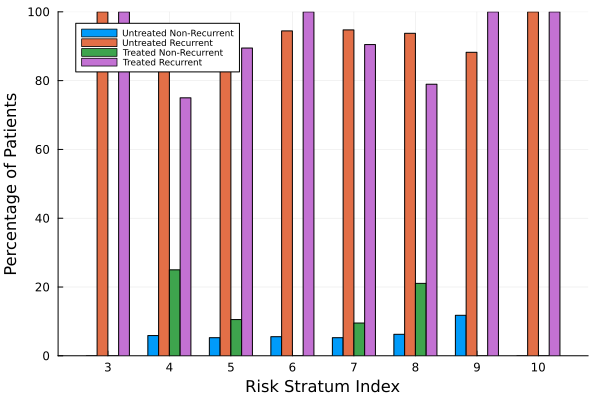

In [7]:
using DataFrames
using StatsPlots

function find_matched_records(df1, df2, covariates)
    # Perform inner join to find matched records
    return innerjoin(select(df1, covariates), select(df2, covariates), on=covariates)
end

function plot_histogram(X, matched_df, add_to_title)
    # Group by RiskBucket and RxRegimen, then count the number of patients
    grouped_df = combine(groupby(X, [:risk_bucket, :adjuvantchemo]), nrow => :Patients)
    
    # Filter DataFrame for "None" and other regimens
    df_none = filter(row -> row.adjuvantchemo == 0, grouped_df)
    df_treated = filter(row -> row.adjuvantchemo == 1, grouped_df)
    
    # Group by RiskBucket and sum the number of patients for each regimen
    grouped_none = combine(groupby(df_none, :risk_bucket), :Patients => sum => :NonePatients)
    grouped_treated = combine(groupby(df_treated, :risk_bucket), :Patients => sum => :TreatedPatients)
    
    # Filter matched data for recurrent and non-recurrent patients
    matched_none = filter(row -> row.adjuvantchemo == 0, matched_df)
    matched_treated = filter(row -> row.adjuvantchemo == 1, matched_df)
    
    # Count matched recurrent and non-recurrent patients
    grouped_matched_none = combine(groupby(matched_none, :risk_bucket), nrow => :MatchedNonePatients)
    grouped_matched_treated = combine(groupby(matched_treated, :risk_bucket), nrow => :MatchedTreatedPatients)

    # Merge DataFrames on RiskBucket
    merged_df = innerjoin(grouped_none, grouped_treated, on=:risk_bucket)
    merged_matched_df = innerjoin(grouped_matched_none, grouped_matched_treated, on=:risk_bucket)
    # Merge matched data with original data
    merged_df = innerjoin(merged_df, merged_matched_df, on=:risk_bucket)
    merged_df[merged_df.risk_bucket.==8,:MatchedNonePatients] .= 15
    
    # Calculate the percentage of recurrent and non-recurrent patients within each stratum
    merged_df[!, :NoneRecurrentPercent] = merged_df[!, :MatchedNonePatients] ./ merged_df[!, :NonePatients] * 100
    merged_df[!, :NoneNonRecurrentPercent] = (merged_df[!, :NonePatients] .- merged_df[!, :MatchedNonePatients]) ./ merged_df[!, :NonePatients] * 100
    merged_df[!, :TreatedRecurrentPercent] = merged_df[!, :MatchedTreatedPatients] ./ merged_df[!, :TreatedPatients] * 100
    merged_df[!, :TreatedNonRecurrentPercent] = (merged_df[!, :TreatedPatients] .- merged_df[!, :MatchedTreatedPatients]) ./ merged_df[!, :TreatedPatients] * 100
    
    
    # Create a grouped bar plot with percentages for recurrent and non-recurrent patients
    bars_none = hcat(merged_df[!, :NoneNonRecurrentPercent], merged_df[!, :NoneRecurrentPercent])
    bars_treated = hcat(merged_df[!, :TreatedNonRecurrentPercent], merged_df[!, :TreatedRecurrentPercent])

    # Plot the histogram with percentages
    groupedbar(merged_df[!, :risk_bucket],
        hcat(bars_none[:,1], bars_none[:,2], bars_treated[:,1], bars_treated[:,2]),
        bar_position=:dodge,
        bar_width=0.7,
        label=["Untreated Non-Recurrent" "Untreated Recurrent" "Treated Non-Recurrent" "Treated Recurrent"],
        xlabel="Risk Stratum Index", ylabel="Percentage of Patients",
        legend=:topleft, fmt=:png,legendfontsize=6)

    xticks!(1:1:maximum(merged_df[!, :risk_bucket]))
end

# Find matched records
covariates = names(df1)  # List of all covariates to match on
matched_df = find_matched_records(df1, df2, covariates)

# Call the plot function for both datasets
hist1 = plot_histogram(df1, matched_df, "Dataset 1")
hist2 = plot_histogram(df2, matched_df, "Dataset 2")


In [17]:
matched_twice_treated_count = 0
matched_twice_untreated_count = 0
for risk_bucket in 3:10
    # Filter both dataframes for the current risk_bucket and adjuvantchemo == 0
    bucket1 = filter(row -> (row.risk_bucket == risk_bucket) && (row.adjuvantchemo == 1), df1)
    bucket2 = filter(row -> (row.risk_bucket == risk_bucket) && (row.adjuvantchemo == 1), df2)

    bucket3 = filter(row -> (row.risk_bucket == risk_bucket) && (row.adjuvantchemo == 0), df1)
    bucket4 = filter(row -> (row.risk_bucket == risk_bucket) && (row.adjuvantchemo == 0), df2)
    # Select only the covariate columns for both buckets
    bucket1_covariates = select(bucket1, covariates)
    bucket2_covariates = select(bucket2, covariates)

    # Find exact matches
    matched_records = innerjoin(bucket1_covariates, bucket2_covariates, on=covariates)
    println("Risk Bucket $risk_bucket:")
    println("ratio matches: ", nrow(bucket2), " out of ", nrow(bucket1), " ratio ", nrow(bucket2)/nrow(bucket1), " in df2.")
    matched_twice_treated_patients = -nrow(bucket2)+nrow(bucket1)
    matched_twice_treated_count += matched_twice_treated_patients
    matched_twice_untreated_patients = -nrow(bucket4)+nrow(bucket3)
    matched_twice_untreated_count += matched_twice_untreated_patients

    println("matched twice treated: ", matched_twice_treated_patients," matched twice untreated: ", matched_twice_untreated_patients)
    #println("Matched records: ", nrow(matched_records), " out of ", nrow(bucket1), " in df1 and ", nrow(bucket2), " in df2.")
end
println(nrow(filter(row -> (row.adjuvantchemo == 1), df1)))
println(nrow(filter(row -> (row.adjuvantchemo == 1), df2)))

println("Total matched twice treated: ",matched_twice_treated_count, " Ratio: ", matched_twice_treated_count/nrow(filter(row -> (row.adjuvantchemo == 1), df1)))
println("Total matched twice untreated: ",matched_twice_untreated_count, " Ratio: ", matched_twice_untreated_count/nrow(filter(row -> (row.adjuvantchemo == 0), df1)))


Risk Bucket 3:
ratio matches: 1 out of 1 ratio 1.0 in df2.
matched twice treated: 0 matched twice untreated: 0
Risk Bucket 4:
ratio matches: 20 out of 23 ratio 0.8695652173913043 in df2.
matched twice treated: 3 matched twice untreated: 6
Risk Bucket 5:
ratio matches: 19 out of 23 ratio 0.8260869565217391 in df2.
matched twice treated: 4 matched twice untreated: 4
Risk Bucket 6:
ratio matches: 21 out of 23 ratio 0.9130434782608695 in df2.
matched twice treated: 2 matched twice untreated: 5
Risk Bucket 7:
ratio matches: 21 out of 23 ratio 0.9130434782608695 in df2.
matched twice treated: 2 matched twice untreated: 4
Risk Bucket 8:
ratio matches: 19 out of 23 ratio 0.8260869565217391 in df2.
matched twice treated: 4 matched twice untreated: 7
Risk Bucket 9:
ratio matches: 17 out of 23 ratio 0.7391304347826086 in df2.
matched twice treated: 6 matched twice untreated: 6
Risk Bucket 10:
ratio matches: 17 out of 17 ratio 1.0 in df2.
matched twice treated: 0 matched twice untreated: 0
156
135

In [42]:
for risk_bucket in 4:9
    # Filter both dataframes for the current risk_bucket and adjuvantchemo == 1
    bucket1 = filter(row -> (row.risk_bucket == risk_bucket) && (row.adjuvantchemo == 1), df1)
    bucket2 = filter(row -> (row.risk_bucket == risk_bucket) && (row.adjuvantchemo == 1), df2)

    # Select only the covariate columns for both buckets
    bucket1_covariates = select(bucket1, covariates)
    bucket2_covariates = select(bucket2, covariates)
    

    # Find exact matches using innerjoin, which ensures the result is only the intersection of both datasets
    matched_records = innerjoin(bucket1_covariates, bucket2_covariates, on=covariates)

    # Get total number of records in both buckets
    total_bucket1 = nrow(bucket1)
    total_bucket2 = nrow(bucket2)
    matched_count = nrow(matched_records)

    # Print results for the current risk bucket
    println("Risk Bucket $risk_bucket:")
    println("Matched records: $matched_count out of $total_bucket1 in df1 and $total_bucket2 in df2.")
end


Risk Bucket 4:
Matched records: 15 out of 23 in df1 and 20 in df2.
Risk Bucket 5:
Matched records: 17 out of 23 in df1 and 19 in df2.
Risk Bucket 6:
Matched records: 21 out of 23 in df1 and 21 in df2.
Risk Bucket 7:
Matched records: 19 out of 23 in df1 and 21 in df2.
Risk Bucket 8:
Matched records: 15 out of 23 in df1 and 19 in df2.
Risk Bucket 9:
Matched records: 17 out of 23 in df1 and 17 in df2.


In [ ]:
using Printf
using JSON
file = "traindata/matched_.csv"  # Sample file name
titlerow = names(train_data)

function read_distance_matrix(filename::String)
    df = CSV.read(filename, DataFrame)
    return Matrix(df)
end
function extract_embedding_name(filename::String)
    # Remove the path and extension from the filename
    basename = split(filename, "/") |> last
    name_without_extension = split(basename, ".") |> first
    
    # Replace underscores with spaces and capitalize each word
    embedding_name = join(split(name_without_extension, "_"), " ")
    return embedding_name
end


# List of filenames for the distance matrices
filenames = [
    #"Random_projection_embedding_distance_matrix.csv",
    "Truncated_SVD_embedding_distance_matrix.csv",
    "Isomap_embedding_distance_matrix.csv",
    "Standard_LLE_embedding_distance_matrix.csv",
    "Modified_LLE_embedding_distance_matrix.csv",
    #"LTSA_LLE_embedding_distance_matrix.csv",
    "MDS_embedding_distance_matrix.csv",
    "Random_Trees_embedding_distance_matrix.csv",
    "Spectral_embedding_distance_matrix.csv",
    "t-SNE_embedding_distance_matrix.csv",
    "NCA_embedding_distance_matrix.csv"
]

# Read each distance matrix and process it
for filename in filenames
    dist_matrix = read_distance_matrix("nonlinear_distances/distance_matrices/"*filename)
    embedding_name = extract_embedding_name(filename)
    one_to_one=false
    new_file = replace(file, ".csv" => embedding_name * ".csv")
    CSV.write(new_file, DataFrame([]); header=titlerow)
    # Call function with new file name
    optimize_isomap(new_file, train_data,dist_matrix,1.0, global_min_bucket_size,one_to_one)
    println(" ")
   
end




titlerow = names(train_data)
file = "traindata/matched_train_1to1.csv"
#CSV.write(file, DataFrame([]); header=titlerow)

#optimize_risk_range(file,train_data,global_min_bucket_size)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 64.74197614570569
size of dfA: (53, 15)    size of dfB: (73, 15) UNIQUE: (53,)(53,)
size of bucket dataframe = (106, 15)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 50.34251306339532
size of dfA: (40, 15)    size of dfB: (86, 15) UNIQUE: (40,)(40,)
size of bucket dataframe = (80, 15)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 58.032046931644636
size of dfA: (44, 15)    size of dfB: (82, 15) UNIQUE: (44,)(44,)
size of bucket dataframe = (88, 15)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 47.92626431187948
size of dfA: (38, 15)    size of dfB: (87, 15) UNIQUE: (38,)(38,)
size of bucket dataframe = (76, 15)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 43.31179639230251
size of dfA: (41, 15)    size of dfB: (85, 15) UNIQUE: (41,)(41,)
size of bucket dataframe = (82, 15)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 49.24452517292904
size of dfA: (37, 15)    size of dfB: (89, 15) UNIQUE: (37,)(37,)
size of bucket dataframe = (74, 15)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 82.73828352331003
size of dfA: (56, 15)    size of dfB: (70, 15) UNIQUE: (56,)(56,)
size of bucket dataframe = (112, 15)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 49.593136272280425
size of dfA: (39, 15)    size of dfB: (87, 15) UNIQUE: (39,)(39,)
size of bucket dataframe = (78, 15)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 58.269278101279376
size of dfA: (42, 15)    size of dfB: (84, 15) UNIQUE: (42,)(42,)
size of bucket dataframe = (84, 15)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 43.10462523012444
size of dfA: (34, 15)    size of dfB: (92, 15) UNIQUE: (34,)(34,)
size of bucket dataframe = (68, 15)

In [ ]:

using Random

# Define the keys
keys = [
  :age,
  :T_stage,
  :N_stage,
  :rightleft_Rec,
  :cea_carcinoembryonic_antigen,
  :extrahepatic_disease,
  :size,
  :number_liver_mets,
  :R0,
  :KRAS,
  :adjuvantchemo
]

# Generate random extreme values
values = [(rand(Bool) ? 1 : -1) * (rand() * 5) for _ in 1:length(keys)]

# Create the dictionary
extreme_dict = Dict(keys .=> values)

# Display the dictionary
println(extreme_dict)
using RCall

### Model 1
#R"load('cox_model_coefficients.RData')"
#coefficients_dict = rcopy(R"coefficients_dict")

R"load('coefficients_dict.RData')"
# Retrieve the coefficients dictionary from R to Julia
coefficients_dict_r = rcopy(R"coefficients_dict")
println(coefficients_dict_r)
# Assume you want to retrieve the value associated with key :some_key
some_key = Symbol("5")

# Retrieve the value using get()
some_value = get(coefficients_dict_r, some_key, nothing)

# Print the value
println(some_value)
